# 결측치 제거 

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/Users/chung/Library/Fonts/NanumGothic.otf', 
    name='NanumGothic')                     
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가 (0,fe):가장 우선순위로 추가하겠다는 뜻
plt.rcParams.update({'font.size': 11, 'font.family': 'NanumGothic'}) # 폰트 설정
plt.rc('font', family='NanumGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np

# from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)   
pd.set_option('display.max_colwidth', None)  

train_path = '/root/ML_Contest/data/train.csv'
test_path  = '/root/ML_Contest/data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

dt['data_type'] = 'train'
dt_test['data_type'] = 'test'

concat = pd.concat([dt, dt_test])    


concat_clean = concat.copy()

concat_clean['등기신청일자'] = concat_clean['등기신청일자'].replace(' ', np.nan)
concat_clean['거래유형'] = concat_clean['거래유형'].replace('-', np.nan)
concat_clean['중개사소재지'] = concat_clean['중개사소재지'].replace('-', np.nan)

print("\n" + "="*80 + "\n") 

# 결측치 기준으로 컬럼 나누기 (복사본 사용)
low_null_cols = list(concat_clean.columns[concat_clean.isnull().sum() <= 1000000])
high_null_cols = list(concat_clean.columns[concat_clean.isnull().sum() > 1000000])

print("\033[31m* 결측치가 100만개 이하인 변수들 :\033[0m", low_null_cols)
print("\n\n")
print("\033[31m* 결측치가 100만개 이상인 변수들 :\033[0m", high_null_cols)

print("\n" + "="*80 + "\n") 

# 결측치 적은 컬럼들만 다시 복사 (여기서 진짜 concat_select 생성)
concat_select = concat_clean[low_null_cols].copy()

concat_select['본번'] = concat_select['본번'].apply(str)
concat_select['부번'] = concat_select['부번'].apply(str)

# 연속형 / 범주형 자동 분리
continuous_columns = concat_select.select_dtypes(include=['number']).columns.tolist()
categorical_columns = concat_select.select_dtypes(exclude=['number']).columns.tolist()

concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 우선 제거 대상 변수
remove_cols = ['k-관리비부과면적', 'k-전체세대수', 'k-연면적']

# 제거 적용
reduced_data = concat_select.drop(columns=remove_cols)

# 보간 대상 변수 목록
interpolate_cols = ['k-전체동수', 'k-주거전용면적', '주차대수','건축면적']

# 선형 보간 적용 (각 컬럼별로 독립적으로)
for col in interpolate_cols:
    reduced_data[col] = reduced_data[col].interpolate(method='linear', limit_direction='both')

# 결측 → 0으로 처리할 변수 리스트
zero_fill_cols = [
    'k-전용면적별세대현황(60㎡이하)',
    'k-전용면적별세대현황(60㎡~85㎡이하)',
    'k-85㎡~135㎡이하'
]

# 결측치 → 0으로 채우기 (inplace 적용)
reduced_data[zero_fill_cols] = reduced_data[zero_fill_cols].fillna(0)

# 적용 결과 확인 (선택)
print(reduced_data[zero_fill_cols].isnull().sum())




* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'data_type']



* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
dtype: int64


In [3]:
# 1. 데이터 불러오기
seoul_apt = pd.read_csv('서울시 공동주택 아파트 정보.csv', encoding='cp949')

# 2. 도로명 + 상세주소 합치기 → '도로명 주소' 컬럼 생성
seoul_apt['도로명'] = seoul_apt['주소(도로명)'].astype(str).str.strip() + ' ' + seoul_apt['주소(도로상세주소)'].astype(str).str.strip()

# 3. 필요한 컬럼만 추출
seoul_apt = seoul_apt[['도로명', '좌표X', '좌표Y']]

# 4. 데이터 타입 변경
seoul_apt['좌표X'] = pd.to_numeric(seoul_apt['좌표X'], errors='coerce')

# 5. Merge (좌표 매핑)
merged_data = pd.merge(
    reduced_data,
    seoul_apt,
    on='도로명',
    how='left',
    suffixes=('', '_외부')
)

# 6. 좌표 결측치 채우기 (외부 좌표로)
merged_data['좌표X'] = merged_data['좌표X'].fillna(merged_data['좌표X_외부'])
merged_data['좌표Y'] = merged_data['좌표Y'].fillna(merged_data['좌표Y_외부'])

# 7. 불필요한 컬럼 삭제
merged_data = merged_data.drop(columns=['좌표X_외부', '좌표Y_외부', '도로명'])

# 8. 좌표X, 좌표Y 선형 보간 (양방향 보간)
merged_data['좌표X'] = merged_data['좌표X'].interpolate(method='linear', limit_direction='both')
merged_data['좌표Y'] = merged_data['좌표Y'].interpolate(method='linear', limit_direction='both')



In [4]:
# 1. 전체 결측치 개수 확인 (컬럼별)
missing_summary = merged_data.isnull().sum()

# 2. 결측치가 존재하는 컬럼만 필터링
missing_columns = missing_summary[missing_summary > 0]

# 3. 결과 출력
print("📌 전체 결측치 현황 (결측치가 있는 컬럼만):\n")
for col, missing_count in missing_columns.items():
    print(f" - {col}: {missing_count:,}개")

# 4. 결측치 있는 컬럼명만 리스트로 추출 (필요시)
missing_cols_list = missing_columns.index.tolist()

📌 전체 결측치 현황 (결측치가 있는 컬럼만):

 - target: 9,915개


# 이상치 제거

In [5]:
# 연속형 변수 추출
numeric_cols = merged_data.select_dtypes(include=['number']).columns.tolist()

# 1. train 데이터만 필터링
train_data = merged_data[merged_data['data_type'] == 'train']

# 2. 이상치 분석 (train 데이터 기준)
outlier_summary = {}

for col in numeric_cols:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = train_data[(train_data[col] < lower_bound) | (train_data[col] > upper_bound)]
    outlier_count = outliers.shape[0]
    outlier_ratio = outlier_count / train_data.shape[0] * 100

    outlier_summary[col] = {'이상치 개수': outlier_count, '비율(%)': round(outlier_ratio, 2)}

# 3. 결과 정리
outlier_df = pd.DataFrame(outlier_summary).T.sort_values(by='비율(%)', ascending=False)

display(outlier_df)



,이상치 개수,비율(%)
k-전용면적별세대현황(60㎡~85㎡이하),217947.0,18.25
k-전용면적별세대현황(60㎡이하),208115.0,17.42
k-85㎡~135㎡이하,157622.0,13.20
건축면적,119463.0,10.00
주차대수,118578.0,9.93
k-주거전용면적,110937.0,9.29
k-전체동수,108276.0,9.07
전용면적(㎡),90595.0,7.58
target,80775.0,6.76
층,11301.0,0.95


In [6]:
target_cols = ['건축면적', '주차대수', 'k-주거전용면적', 'k-전체동수', '전용면적(㎡)']

# 이상치 제거 함수 (train 데이터만)
def remove_outliers_iqr(df, cols):
    # 1. train 데이터만 필터링
    train_df = df[df['data_type'] == 'train'].copy()
    test_df = df[df['data_type'] != 'train'].copy()   # test 데이터는 그대로
    
    # 2. 각 변수에 대해 이상치 제거
    for col in cols:
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        train_df = train_df[(train_df[col] >= lower_bound) & (train_df[col] <= upper_bound)]
    
    # 3. train과 test 다시 합치기
    cleaned_df = pd.concat([train_df, test_df]).sort_index()
    
    return cleaned_df

# 적용
merged_data_clean = remove_outliers_iqr(merged_data, target_cols)

In [7]:
print("Before:", merged_data.shape)
print("After:", merged_data_clean.shape)

print("\n" + "="*80 + "\n") 

print(merged_data['data_type'].value_counts())
print(merged_data_clean['data_type'].value_counts())

Before: (1204322, 41)
After: (843447, 41)


data_type
train    1194407
test        9915
Name: count, dtype: int64
data_type
train    833532
test       9915
Name: count, dtype: int64


# Feature 추가 

In [8]:
clean_data = merged_data_clean.copy()

In [9]:
# 지하철 데이터
subway_df = pd.read_csv('/root/ML_Contest/data/subway_feature.csv')
subway_coords = np.radians(subway_df[['위도', '경도']].values)

# 2. 거리 계산 함수 (벡터화된 haversine)
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371000  # 지구 반지름 (m)
    dlat = lat2 - lat1[:, np.newaxis]      # Broadcasting
    dlon = lon2 - lon1[:, np.newaxis]
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1[:, np.newaxis]) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# 3. 아파트 좌표 (clean_data 기준)
apt_coords = np.radians(clean_data[['좌표Y', '좌표X']].values)
apt_lat, apt_lon = apt_coords[:, 0], apt_coords[:, 1]
sub_lat, sub_lon = subway_coords[:, 0], subway_coords[:, 1]

# 4. 거리 계산 (아파트 ↔ 지하철역)
distances = haversine_vectorized(apt_lat, apt_lon, sub_lat, sub_lon)

# 5. 800m 반경 내 지하철역 개수 계산
within_800m = (distances <= 800).sum(axis=1)

# 6. 결과 컬럼 추가
clean_data['800m_지하철역_개수'] = within_800m


# Model Training
- 2025.07.14



In [10]:
# 이제 다시 train과 test dataset을 분할해줍니다. 
dt_train = clean_data.query("data_type == 'train'")
dt_test = clean_data.query("data_type == 'test'")

# 이제 data_type 칼럼은 drop.
dt_train.drop(['data_type'], axis = 1, inplace=True)
dt_test.drop(['data_type'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(833532, 41) (9915, 41)


In [11]:
print('data_type' in dt_train.columns)  # False여야 정상
print('data_type' in dt_test.columns) 

False
False


In [12]:
dt_test.head(1)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-주거전용면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,800m_지하철역_개수
1194407,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,우성건설,모름,1987-11-21 00:00:00.0,20204.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NULL,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,NaN,0


In [13]:
# dt_test의 target은 일단 0으로 임의로 채워주기
dt_test['target'] = 0

### 범주형 변수 Encoding

In [14]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '800m_지하철역_개수']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


In [15]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [16]:
from tqdm import tqdm

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.inspection import permutation_importance

In [17]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 25/25 [00:03<00:00,  6.79it/s]


In [18]:
dt_train.head(1) 

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-주거전용면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,800m_지하철역_개수
0,0,4208,1095,1,275,79.97,201712,8,3,1987,3,378,342,2,2,1,1,8.0,211,176,21,20204.0,20.0,250.0,0.0,161,426,4,1,4,4858.0,262.0,4,581,1,0,127.05721,37.476763,196,124000.0,0


### Model training


In [19]:
assert dt_train.shape[1] == dt_test.shape[1]          

# train/test dataset의 shape이 같은지 확인.
#True인 경우 넘어감. False인 경우 (조건을 만족하지 않는 경우) 에러를 발생시켜 프로그램 중단

In [20]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)



In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor


🔍 Model 성능 비교 (낮을수록 좋음):
              Model          RMSE
2      RandomForest   4672.443331
3           XGBoost   8620.201193
0  LinearRegression  23694.443667
1             Ridge  23694.458789


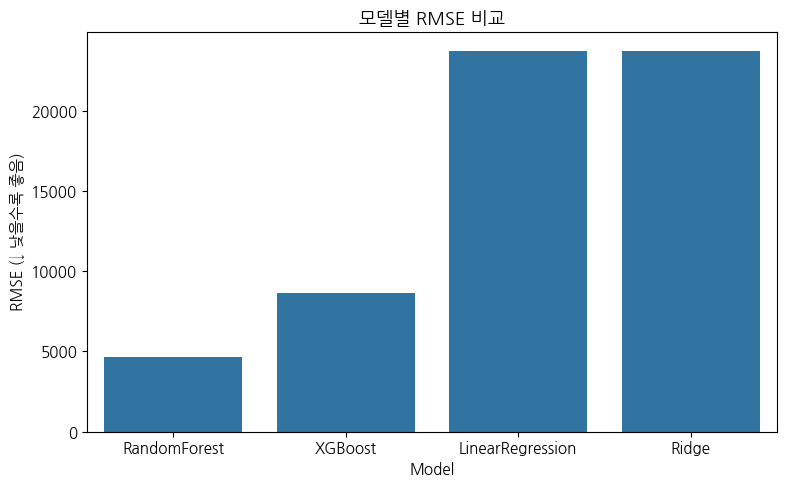

In [24]:
# ✅ 사용할 모델 정의
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=1, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=1, n_jobs=-1),
    #'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=1, n_jobs=-1)
}

# ✅ 결과 저장 리스트
results = []

# ✅ 모델 학습 및 RMSE 계산 루프
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    results.append({'Model': name, 'RMSE': rmse})

# ✅ 결과 정리 및 출력
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True)
print("🔍 Model 성능 비교 (낮을수록 좋음):")
print(results_df)

# ✅ 시각화
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Model', y='RMSE')
plt.title("모델별 RMSE 비교")
plt.ylabel("RMSE (↓ 낮을수록 좋음)")
plt.xlabel("Model")
plt.tight_layout()
plt.show()